# Compression Test

Compression evaluation based on the Hertzian Model

In [ ]:
from isaacsim import SimulationApp
simulation_app = SimulationApp({"headless": False})



# ─────────────────────────────────────────────
# Standard Python
# ─────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
import csv
import torch
from IPython.display import display


# ─────────────────────────────────────────────
# Isaac Sim Core
# ─────────────────────────────────────────────
from isaacsim.core.api import World
from isaacsim.core.api.objects import DynamicSphere, FixedCuboid

# Deformable API (for later block swap)
from isaacsim.core.api.materials.deformable_material import DeformableMaterial
from isaacsim.core.prims import DeformablePrim
import isaacsim.core.utils.deformable_mesh_utils as deformableMeshUtils

# ─────────────────────────────────────────────
# Sensors
# ─────────────────────────────────────────────
from isaacsim.sensors.physics import ContactSensor

# ─────────────────────────────────────────────
# Physics / USD
# ─────────────────────────────────────────────
from omni.physx.scripts import physicsUtils  # enable force reporting, etc.
from pxr import UsdGeom, UsdPhysics          # USD schemas (mass, collision)

from omni.physx.scripts import physicsUtils

Starting kit application with the following args:  ['/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts/isaacsim.simulation_app/isaacsim/simulation_app/simulation_app.py', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps/isaacsim.exp.base.python.kit', '--/app/tokens/exe-path=/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--/app/installSignalHandlers=0', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps', '

🟥 Rigid cube created at Z = 0.02 m
🟡 Indenter sphere at Z = 55.0 mm (10 mm above cube)
🔧 Prismatic joint created (no PhysX API layer)
tensor(0.0550, device='cuda:0')
True
Terminal only
Terminal only
Terminal only
Terminal only
Terminal only
Terminal only
⏵ Ready — Press PLAY to start indentation
⏹ STOP detected → Test finished


### Simulation parameters

In [2]:
### USER CONSTANTS ###
BLOCK_SIZE     = 0.04        # 40 mm silicone cube edge
SPHERE_RADIUS  = 0.005       # 5 mm radius = 10 mm indenter diameter
DT             = 1/60    # use 240 Hz for deformables (recommended)

CSV_TAG   = "silicone10mmSphere_6mmComp"
CSV_FILE  = f"{CSV_TAG}_results.csv"
PLOT_FILE = f"{CSV_TAG}_plot.png"

### GUI Panel

In [3]:
def create_world():
    world = World(stage_units_in_meters=1.0, backend="torch", device="cuda")
    world.scene.add_default_ground_plane()
    return world, world.stage


def create_rigid_block(world):
    """
    Creates a 40 mm rigid cube resting on the ground plane.
    Used for calibration before switching to deformable block.
    """

    block = world.scene.add(
        FixedCuboid(
            prim_path="/RigidBlock",
            name="rigid_block",
            position=np.array([0.0, 0.0, BLOCK_SIZE / 2.0]),  # bottom at z=0
            size=BLOCK_SIZE,       # 0.04 m = 40 mm cube
            color=np.array([200, 50, 50])   # reddish
        )
    )

    print("🟥 Rigid cube created at Z =", BLOCK_SIZE/2.0, "m")

    return block



def create_dynamic_sphere(world):
    block_top = BLOCK_SIZE                  # 0.04 m
    gap = 0.01                              # 1 mm
    start_z = block_top + SPHERE_RADIUS + gap  # 0.04 + 0.005 + 0.001 = 0.046 m

    sphere = world.scene.add(
        DynamicSphere(
            prim_path="/Sphere",
            name="indenter",
            radius=SPHERE_RADIUS,  # 0.005 m
            position=np.array([0, 0, start_z]),
            mass=0.01,             # 10 g
            color=np.array([255,255,0])
        )
    )

    print(f"🟡 Indenter sphere at Z = {start_z*1000:.1f} mm "
          f"({gap*1000:.0f} mm above cube)")
    return sphere


## Sensor and Prismatic Joint

In [4]:
def attach_contact_sensor(world):
    sensor = world.scene.add(
        ContactSensor(
            prim_path="/Sphere/sensor",
            name="sphere_sensor",
            radius=0.005,
            min_threshold=0.0,
            max_threshold=1e6,
        )
    )
    sensor.add_raw_contact_data_to_frame()
    return sensor


def create_prismatic_joint(stage):
    joint = UsdPhysics.PrismaticJoint.Define(stage, "/World/JointZ")
    joint.CreateAxisAttr("Z")

    # ----------------------------------------
    # 6 mm indentation limits (27 mm -> 21 mm)
    # ----------------------------------------
    joint.CreateUpperLimitAttr(0.055)   # starting height (2 mm above)
    joint.CreateLowerLimitAttr(0.041)   # 6 mm indentation


    # static reference body
    xform = UsdGeom.Xform.Define(stage, "/World/Ref")
    joint.CreateBody0Rel().SetTargets(["/World/Ref"])

    # joint drives the sphere
    joint.CreateBody1Rel().SetTargets(["/Sphere"])

    # drive setup
    drive = UsdPhysics.DriveAPI.Apply(joint.GetPrim(), "linear")
    drive.CreateTypeAttr().Set("position")
    drive.CreateStiffnessAttr().Set(2e5)
    drive.CreateDampingAttr().Set(1e4)

    print("🔧 Prismatic joint created (no PhysX API layer)")

    # ⛔️ RETURN *ONLY* THIS
    return drive



### Simulation Loop

In [5]:
def run_test(world, drive, sensor, sphere):
    time_log, disp_log, force_log = [], [], []
    sim_time = 0.0

    target = 0.055   # sphere center 2 mm above the cube
    direction = -1

    # 🔑 FIX: command start height before running sim
    drive.GetTargetPositionAttr().Set(target)

    print("⏵ Ready — Press PLAY to start indentation")

    while simulation_app.is_running():

        if world.is_playing():

            sim_time += DT
            time_log.append(sim_time)

            # Move the indenter 6 mm down and back
            target += 0.0001 * direction   # slow, precise indentation

            if target <= 0.041: direction = +1   # reached 6 mm compression
            elif target >= 0.055: direction = -1

            drive.GetTargetPositionAttr().Set(target)

            # Actual sphere position
            disp_log.append(sphere.get_world_pose()[0][2])

            # Contact force from sensor
            frame = sensor.get_current_frame()
            fn = float(frame["force"][2]) if frame["in_contact"] else 0.0
            force_log.append(abs(fn))

        # STOP ends test and returns data
        if world.is_stopped() and len(time_log) > 10:
            print("⏹ STOP detected → Test finished")
            return time_log, disp_log, force_log

        world.step(render=True)



### Data Logging

In [ ]:
def save_csv(time, disp, force):
    with open(CSV_FILE, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["time_s", "sphere_z_m", "normal_force_N"])
        for t, z, fn in zip(time, disp, force):
            w.writerow([t, z, fn])
    print("🧾 CSV saved →", CSV_FILE)

def save_plot(time, disp, force):

    def to_np(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        if isinstance(x, (list, tuple)):
            return np.array([to_np(v) for v in x])
        return np.array(x)

    time  = to_np(time)
    disp  = to_np(disp)
    force = to_np(force)

    plt.figure(figsize=(7,4))
    plt.plot(disp, force, linewidth=2)
    plt.xlabel("Sphere Displacement (m)")
    plt.ylabel("Normal Force (N)")
    plt.title("Sphere Compression — Force vs Displacement")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(PLOT_FILE, dpi=300)
    plt.show()
    display("Finished Plot")
    # print("📈 Plot saved →", PLOT_FILE)

### World and Scene Setup

In [7]:

world, stage = create_world()
block = create_rigid_block(world)
sphere = create_dynamic_sphere(world)
sensor = attach_contact_sensor(world)
drive = create_prismatic_joint(stage)
world.reset()

In [9]:
from pxr import UsdPhysics

frame = sensor.get_current_frame()
frame.keys()
print(sphere.get_world_pose()[0][2])

print(sphere.prim.HasAPI(UsdPhysics.CollisionAPI))


In [ ]:
print("Terminal only")
from IPython.display import display
display("Notebook visible")
display({"x": 10, "y": 20})
display(BLOCK_SIZE)
print(sphere)

'Notebook visible'

{'x': 10, 'y': 20}

0.04

<bound method SingleRigidPrim.get_angular_velocity of <isaacsim.core.api.objects.sphere.DynamicSphere object at 0x71461c6ed150>>

In [16]:
# world.reset(soft=False)
time, disp, force = run_test(world, drive, sensor, sphere)


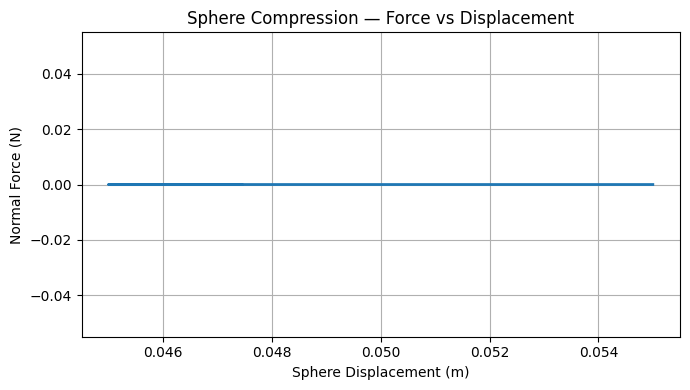

In [10]:
# save_csv(time, disp, force)
save_plot(time, disp, force)

In [ ]:
simulation_app.close()